In [1]:
import json
import os
from os.path import join
from itertools import product
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from bct.algorithms.modularity import community_louvain, partition_distance
from dn_utils.plotting import plot_matrix
from dn_utils.path import path

%matplotlib inline

/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/code/dn_utils/glm_utils.py:13: FutureWarning: 

 | Starting with Nilearn 0.7.0, all Nistats functionality has been incorporated into Nilearn's stats & reporting modules.
 | Nistats package will no longer be updated or maintained.

  from nistats import design_matrix


In [2]:
path_corrmats = join(path["bsc"], 'corrmats')

## Settings

In [3]:
atlas = 'combined_roi'

### Load data

In [4]:
# Load correlation matrices and metadata
corrmats_aggregated = np.load(
    join(path_corrmats, atlas, 'corrmats_aggregated.npy'))
with open(join(path_corrmats, atlas, 'corrmats_aggregated.json'), 'r') as f:
    meta = json.loads(f.read())

# Load subject exclusion
df_exclusion = pd.read_csv(
    join(path["nistats"], 'exclusion/exclusion.csv'), index_col=0)
ok_index = df_exclusion['ok_all']    
corrmats_aggregated = corrmats_aggregated[ok_index]

# Load ROI information
df_roi = pd.read_csv(join(path_corrmats, atlas, 'roi_table_filtered.csv'))

n_subjects = len(meta['dim1'])
n_subjects_ok = sum(ok_index)
n_conditions = len(meta['dim2'])
n_perr_sign = len(meta['dim3'])
n_rois = len(df_roi)

iters = product(range(n_subjects_ok), range(n_conditions), range(n_perr_sign))
iters = list(iters)

In [5]:
louvain_B = 'negative_asym'
louvain_reps = 1
gamma_range = np.arange(0.05, 3.05, 0.05)
gamma_range

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05, 1.1 ,
       1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 , 1.65,
       1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05, 2.1 , 2.15, 2.2 ,
       2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 , 2.65, 2.7 , 2.75,
       2.8 , 2.85, 2.9 , 2.95, 3.  ])

In [6]:
stats = np.zeros((len(gamma_range), 6))

for gamma_i, gamma in tqdm(list(enumerate(gamma_range))):
    print(f"iteration {gamma_i} (gamma={gamma})")
    
    # Calculate modularity for specific gamma
    m_aggregated = np.zeros((n_subjects_ok, n_conditions, n_perr_sign, n_rois))
    q_aggregated = np.ones((n_subjects_ok, n_conditions, n_perr_sign)) * (-np.inf)

    for sub_idx, con_idx, perr_sign_idx in iters:
        corrmat = corrmats_aggregated[sub_idx, con_idx, perr_sign_idx]
        corrmat[np.diag_indices_from(corrmat)] = 0
        for _ in range(louvain_reps):
            m, q = community_louvain(corrmat, gamma=gamma, B=louvain_B)
            if q > q_aggregated[sub_idx, con_idx, perr_sign_idx]:
                m_aggregated[sub_idx, con_idx, perr_sign_idx] = m
                q_aggregated[sub_idx, con_idx, perr_sign_idx] = q

    # Number of communities
    n_communities = np.max(m_aggregated, axis=(3))
    n_singleton = np.array(
        [
            [
                [
                    np.sum(np.unique(m_aggregated[sub, con, perr], return_counts=True)[1] == 1)
                    for perr in range(n_perr_sign)
                ]
                for con in range(n_conditions)
            ]
            for sub in range(n_subjects_ok)
        ]
    )
    n_nonsingleton = n_communities - n_singleton

    # Partition similarity
    m_stacked = np.reshape(
        m_aggregated, 
        (n_subjects_ok * n_conditions * n_perr_sign, n_rois)
    )
    pd = np.zeros((len(m_stacked), len(m_stacked)))
    for i in range(len(m_stacked)):
        for j in range(i + 1, len(m_stacked)):
            pd[i, j] = partition_distance(m_stacked[i], m_stacked[j])[1]
    pd[np.diag_indices_from(pd)] = np.nan

    h_total = np.nansum(pd)
    h_within = np.nansum(
        np.hstack(
            [
                pd[
                    n_subjects_ok * n : n_subjects_ok * (n + 1),
                    n_subjects_ok * n : n_subjects_ok * (n + 1),
                ]
                for n in range(4)
            ]
        )
    )
    h_between = h_total - h_within

    n_total = (n_subjects_ok * 4) * (n_subjects_ok * 4 - 1) / 2
    n_within = 4 * n_subjects_ok * (n_subjects_ok - 1) / 2
    n_between = n_total - n_within

    h_total_mean = h_total / n_total
    h_within_mean = h_within / n_within
    h_between_mean = h_between / n_between
    
    stats[gamma_i] = np.array([
        np.mean(n_communities),
        np.mean(n_singleton),
        np.mean(n_nonsingleton),
        h_total_mean,
        h_within_mean,
        h_between_mean
    ])

  0%|          | 0/60 [00:00<?, ?it/s]

iteration 0 (gamma=0.05)


/home/kmb/miniconda3/envs/decidenet/lib/python3.8/site-packages/bct/algorithms/modularity.py:1729: RuntimeWarning: invalid value encountered in double_scalars
  Min = 2 * (Hx + Hy - Hxy) / (Hx + Hy)


iteration 1 (gamma=0.1)
iteration 2 (gamma=0.15000000000000002)
iteration 3 (gamma=0.2)
iteration 4 (gamma=0.25)
iteration 5 (gamma=0.3)
iteration 6 (gamma=0.35000000000000003)
iteration 7 (gamma=0.4)
iteration 8 (gamma=0.45)
iteration 9 (gamma=0.5)
iteration 10 (gamma=0.55)
iteration 11 (gamma=0.6000000000000001)
iteration 12 (gamma=0.6500000000000001)
iteration 13 (gamma=0.7000000000000001)
iteration 14 (gamma=0.7500000000000001)
iteration 15 (gamma=0.8)
iteration 16 (gamma=0.8500000000000001)
iteration 17 (gamma=0.9000000000000001)
iteration 18 (gamma=0.9500000000000001)
iteration 19 (gamma=1.0)
iteration 20 (gamma=1.05)
iteration 21 (gamma=1.1)
iteration 22 (gamma=1.1500000000000001)
iteration 23 (gamma=1.2000000000000002)
iteration 24 (gamma=1.2500000000000002)
iteration 25 (gamma=1.3)
iteration 26 (gamma=1.35)
iteration 27 (gamma=1.4000000000000001)
iteration 28 (gamma=1.4500000000000002)
iteration 29 (gamma=1.5000000000000002)
iteration 30 (gamma=1.55)
iteration 31 (gamma=1.6)
i

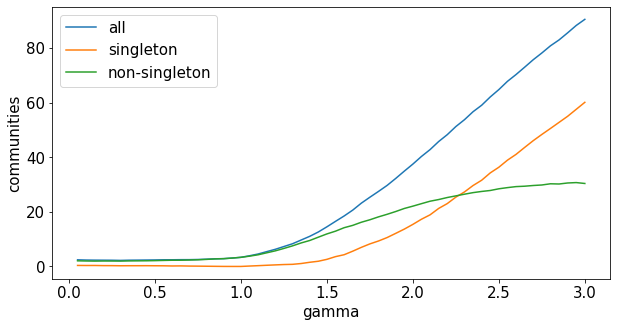

In [9]:
mpl.rcParams["font.size"] = 15
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(gamma_range, stats[:, :3])
ax.set_xlabel("gamma")
ax.set_ylabel("communities")
plt.legend(["all", "singleton", "non-singleton"])

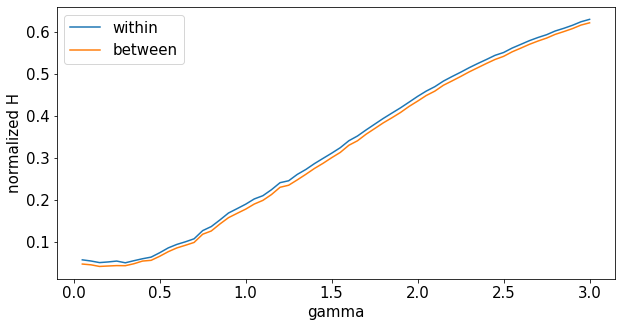

In [30]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(gamma_range, stats[:, 3])
ax.set_xlabel("gamma")
ax.set_ylabel("normalized H")
plt.legend(["within", "between"])